In [3]:
import numpy as np
from data_cube_analysis import getdata, rms, masks, moments
from astropy import units as u 
from astropy.convolution import convolve_fft, convolve, Gaussian2DKernel
from astropy.io import fits
import matplotlib.pyplot as plt
import spectral_cube
import aplpy
from math import ceil
import pyspeckit
import colorcet
import matplotlib as mpl
from glob import glob 

plt.style.use('paper')

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
inputfiles = glob('/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_bubble/*TP_7M_12M_weighted_mosaic.K.kms.galactic.max.fits')
inputfiles.remove('/Users/abarnes/Dropbox/work/Smallprojects/aces/data/alma/12m7mtp_bubble/h13co+10.TP_7M_12M_weighted_mosaic.K.kms.galactic.max.fits')
inputfiles.sort()

hdus = ['']*(len(inputfiles))

for i, inputfile in enumerate(inputfiles): 
    
    # remove h13co
    if 'h13co' in inputfile:
        continue
        
    #smooth hnco
    if 'hnco' in inputfile:
        hdu_hnco = fits.open(inputfile)[0]
        gauss_kernel = Gaussian2DKernel(5)
        hdu_hnco.data = convolve_fft(hdu_hnco.data, gauss_kernel, nan_treatment='interpolate')

    hdus[i] = fits.open(inputfile)[0]
    gauss_kernel = Gaussian2DKernel(1)
    hdus[i].data = convolve(hdus[i].data, gauss_kernel, nan_treatment='interpolate')

nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid this.


In [5]:
bbox = dict(facecolor='whitesmoke', 
            alpha=0.95, 
            boxstyle='round')

name_dict = {'cs21': 'CS',
            'h13cn10': 'H$^{13}$CN',
            'hc3n1110': 'HC$_3$N',
            'hco+10': 'HCO$^+$',
            'hn13c10': 'HN$^{13}$C',
            'hnco43': 'HNCO',
            'sio21': 'SiO',
            'so3221': 'SO'}

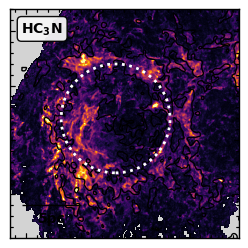

In [41]:
l = 0.8065474
b = -0.19
width = 0.2*0.7
height = 0.2*0.7

fig = plt.figure(figsize=(12, 6)) 
ax = ['']*len(hdus)

for i, hdu in enumerate(hdus): 
    
    if i not in [2]:
        continue
    
    ax[i] = aplpy.FITSFigure(hdu, figure=fig, subplot=(2,4,i+1))

    vmin, vmax = np.nanpercentile(hdu.data, [0.05,99.9])
    ax[i].show_colorscale(cmap='inferno', vmin=vmin, vmax=vmax, stretch='linear', interpolation='none')
    ax[i].show_contour(hdu_hnco, levels=[2.5], colors='black', linewidths=1)
    
    ax[i].recenter(l, b, width=width, height=height)
    ax[i].tick_labels.hide()
    ax[i].axis_labels.hide()
    ax[i].ticks.set_color('black')
    ax[i].set_nan_color('lightgrey')
    ax[i].show_ellipses(0.8119, -0.1868, 240/3600, 240/3600, edgecolor='white', linestyles='dotted', linewidths=2, zorder=10)
    ax[i].add_scalebar(130*u.arcsec, corner='bottom left')
    ax[i].scalebar.set_label('5pc')

    key = inputfiles[i].split('/')[-1].split('.')[0]
    ax[i].add_label(0.05, 0.95, name_dict[key], 
                ha='left', va='top',
                size=10,
                bbox = bbox,
                relative=True)
    
fig.subplots_adjust(wspace=0.02, hspace=0.02)
fig.savefig('../figures/all_max.pdf', bbox_inches='tight', dpi=300)